## Testing Filtering Methods

### Imports

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd
import numpy as np
import os

from py_files.extract import extract_data, extract_metadata

from bycycle import features, cyclepoints, plts

from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.signal import detrend

from neurodsp.filt import filter_signal
from neurodsp.plts import plot_power_spectra
from neurodsp.spectral import compute_spectrum
import neurokit2 as nk

import sys
sys.path.append("../")
from scripts.funcs import *

from scipy.signal import correlate
from scipy.signal import welch

import fooof


In [21]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

#FS = sampling rate; The sampling frequency of `ecg_signal` (in Hz, i.e., samples/second).
FS = 1000


In [22]:
CROP_MIN = 10000
CROP_MAX = 15000
WINDOW_LENGTH = 5000

In [23]:
from py_files.extract import extract_data, extract_metadata
from py_files.simulate_ecg_sig import simulate_ecg_signal
from py_files.find_most_similar_ecg_signal import find_most_similar_signal

### Load Dat

In [24]:
# Data paths
dir_path = '/Users/morganfitzgerald/Projects/ecg_param/data'
files_dat = [i for i in sorted(os.listdir(dir_path)) if i.endswith('dat')]
files_hea = [i for i in sorted(os.listdir(dir_path)) if i.endswith('hea')]
# files_hea = [i for i in files_hea if i != '0400.hea'] # missing one participant's data

In [25]:
# Assuming files_dat is a list of filenames
# Iterate over the list
for filename in files_dat:
    # Extract subject number
    sub_num = os.path.splitext(filename)[0]
    
    # Ensure the extracted part is numeric (remove leading zeros)
    sub_num = str(int(sub_num))
    
    # Define SUB_NUM variable
    SUB_NUM = sub_num
    
    # Print the result
    print(f"Subject Number for {filename}: {SUB_NUM}")

Subject Number for 0001.dat: 1
Subject Number for 0002.dat: 2
Subject Number for 0006.dat: 6
Subject Number for 0007.dat: 7
Subject Number for 0008.dat: 8
Subject Number for 0009.dat: 9
Subject Number for 0010.dat: 10
Subject Number for 0011.dat: 11
Subject Number for 0020.dat: 20


### Select ECG Sig

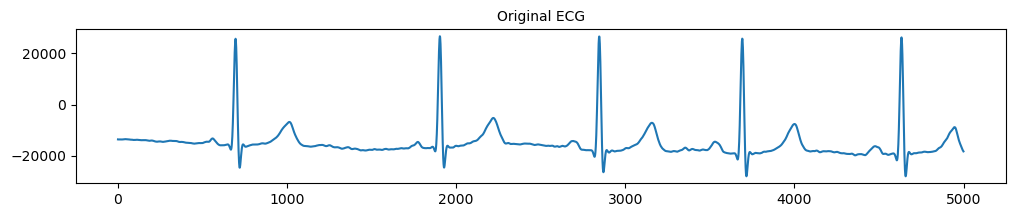

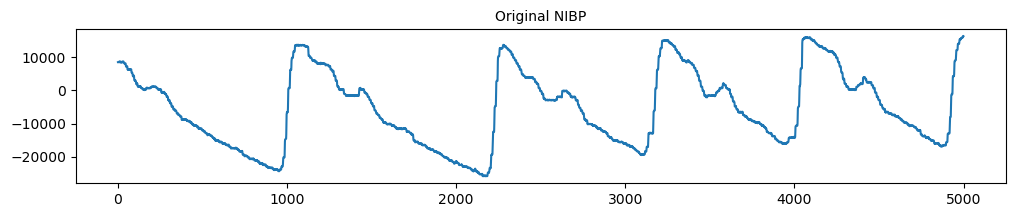

In [27]:
#PLOT THE RAW SIGNALS 

SUB_NUM = 2

# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[SUB_NUM]),
    os.path.join(dir_path, files_hea[SUB_NUM]),
    raw_dtype='int16'
)

# Iterate through signals and plot only the original signals
for ind in range(metadata['n_sigs']):
    plt.figure(figsize=(12, 2))

    # Original signal
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    original_signal = sigs[ind][CROP_MIN:CROP_MAX]
    
    plt.plot(original_signal)
    plt.title(f'Original {signal_name}', size=10)

plt.show()

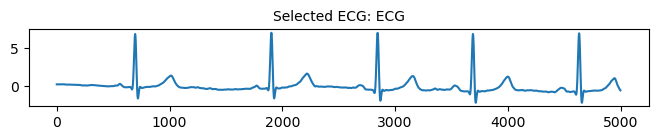

In [28]:
#SELECT THE SIGNAL
# SUB_NUM = 1

# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[SUB_NUM]),
    os.path.join(dir_path, files_hea[SUB_NUM]),
    raw_dtype='int16'
)

# Template ECG signal
template_ecg = simulate_ecg_signal(duration=5, sampling_rate=1000, heart_rate=80, amplitude_factor=7, normalize=False)

# List to store normalized signals
normalized_signals = []

# Iterate through signals and normalize each
for ind in range(metadata['n_sigs']):
    signal_name = metadata[f'sig{str(ind).zfill(2)}']['signal_name']
    
    # Cut the signal shorter before normalization
    cropped_signal = sigs[ind][CROP_MIN:CROP_MAX]

    # Normalize the signal
    normalized_signal = (cropped_signal - np.mean(cropped_signal)) / np.std(cropped_signal)

    # Add normalized signal to the list
    normalized_signals.append(normalized_signal)


# Find the most similar signal to the template using cross-correlation
selected_signal, selected_signal_name, selected_signal_index = find_most_similar_signal(template_ecg, normalized_signals, metadata)

# Plot the most similar signal with the original signal name in the title
plt.figure(figsize=(8, 1))
plt.plot(selected_signal)
plt.title(f'Selected ECG: {selected_signal_name}', size=10)
plt.show()

# Now 'ecg' contains the selected signal
ecg = sigs[selected_signal_index]


### Neurokit Cleaning Methods

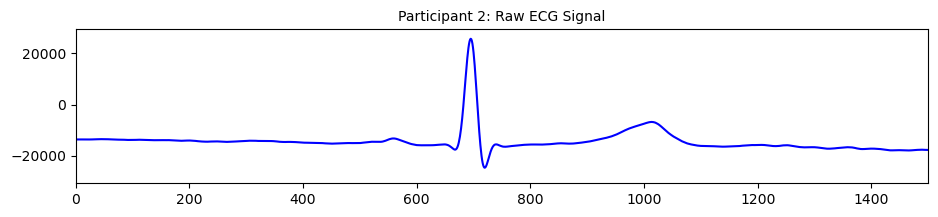

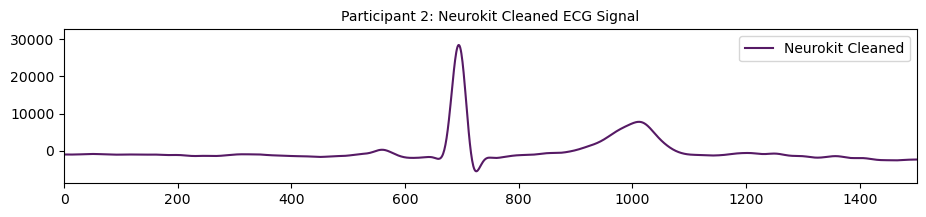

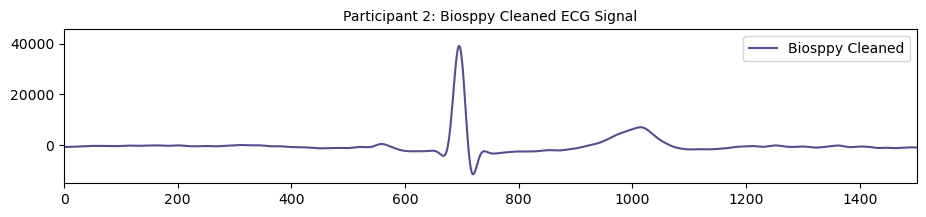

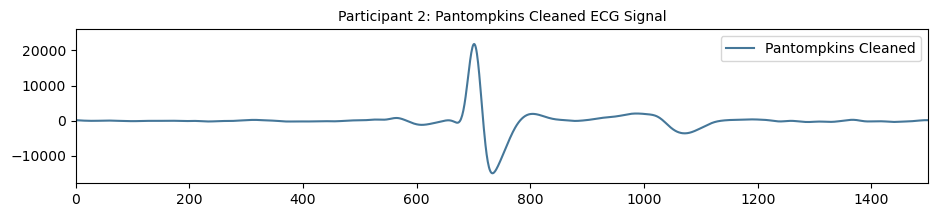

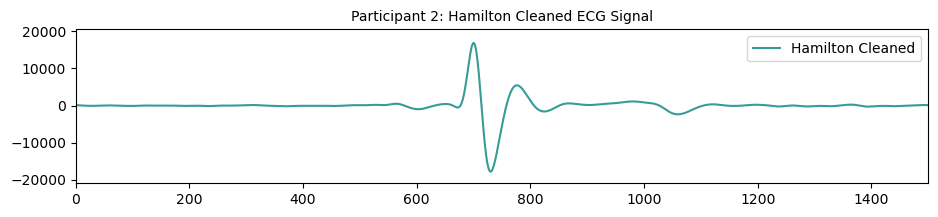

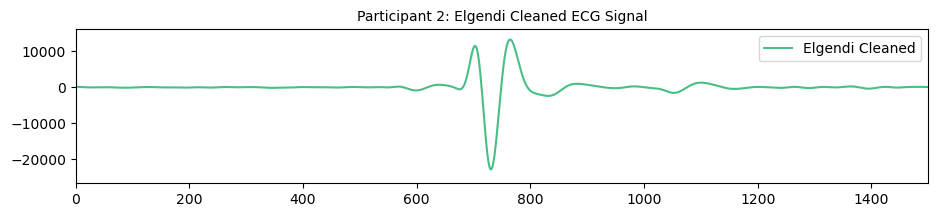

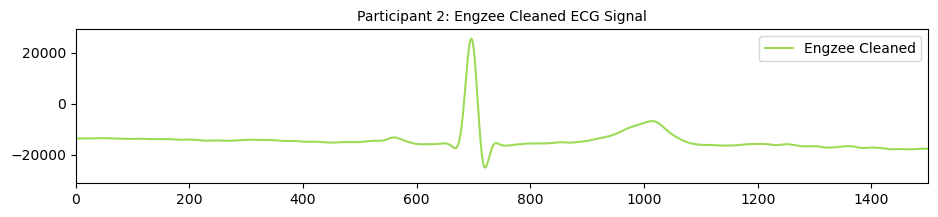

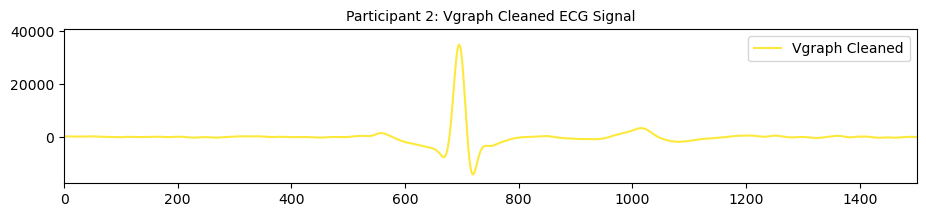

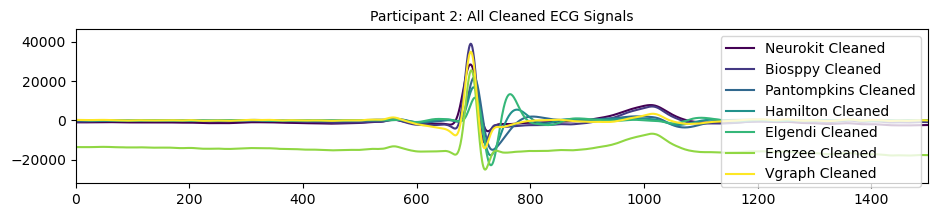

In [29]:
# Original raw ECG signal
plt.figure(figsize=(11, 2))
plt.plot(ecg[CROP_MIN:CROP_MAX], color='b', label='Raw ECG')
plt.title(f'Participant {SUB_NUM}: Raw ECG Signal', size=10)
plt.xlim(0, 1500)  # Limit x-axis to 0-1500 ms

# Create a list to store cleaned signals for each method
cleaned_signals = []

# Apply each cleaning method and store the results
cleaning_methods = ["neurokit", "biosppy", "pantompkins", "hamilton", "elgendi", "engzee", "vgraph"]

# Create a color cycle for cleaned signals
colors = plt.cm.viridis(np.linspace(0, 1, len(cleaning_methods)))

# Create separate plots for cleaned signals
for i, method in enumerate(cleaning_methods):
    # Apply the cleaning method
    if method == "neurokit":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method='neurokit')
    elif method == "biosppy":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="biosppy")
    elif method == "pantompkins":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="pantompkins")
    elif method == "hamilton":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="hamilton")
    elif method == "elgendi":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="elgendi")
    elif method == "engzee":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="engzee")
    elif method == "vgraph":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="vgraph")

    cleaned_signals.append((ecg_cleaned, method, colors[i]))

# Create separate plots for cleaned signals
for ecg_cleaned, method, color in cleaned_signals:
    plt.figure(figsize=(11, 2))
    plt.plot(ecg_cleaned[CROP_MIN:CROP_MAX], label=f'{method.capitalize()} Cleaned', color=color, alpha=0.9)
    plt.title(f'Participant {SUB_NUM}: {method.capitalize()} Cleaned ECG Signal', size=10)
    plt.xlim(0, 1500)  # Limit x-axis to 0-1500 ms
    plt.legend(loc='upper right')
    plt.show()

# Plot all cleaned signals on the same plot
plt.figure(figsize=(11, 2))
for ecg_cleaned, method, color in cleaned_signals:
    plt.plot(ecg_cleaned[CROP_MIN:CROP_MAX], label=f'{method.capitalize()} Cleaned', color=color, alpha=1)

plt.title(f'Participant {SUB_NUM}: All Cleaned ECG Signals', size=10)
plt.xlim(0, 1500)  # Limit x-axis to 0-1500 ms
plt.legend(loc='upper right')
plt.show()

In [ ]:
CROP_MIN = 10000
CROP_MAX = 15000
WINDOW_LENGTH = 5000

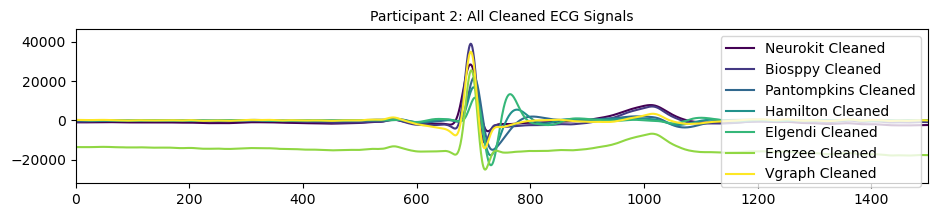

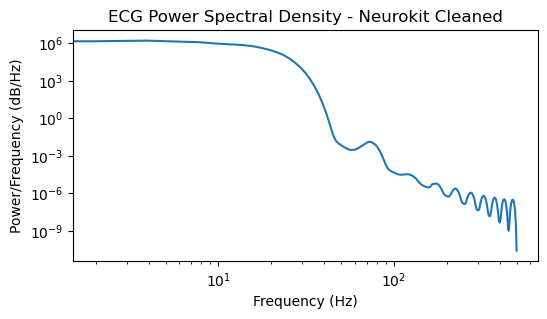

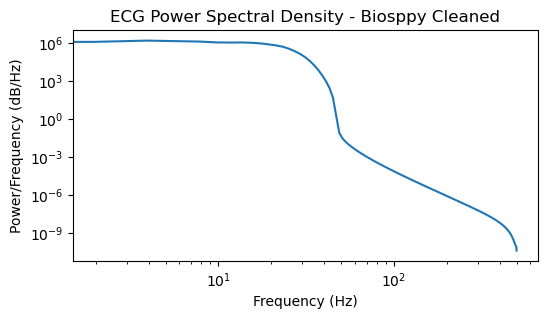

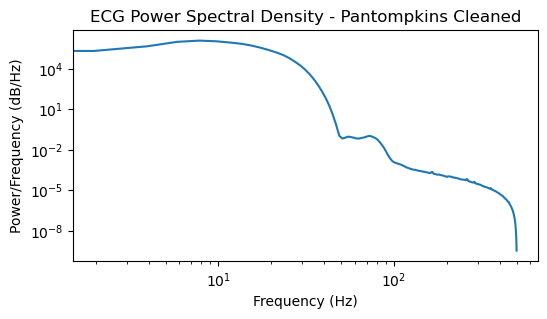

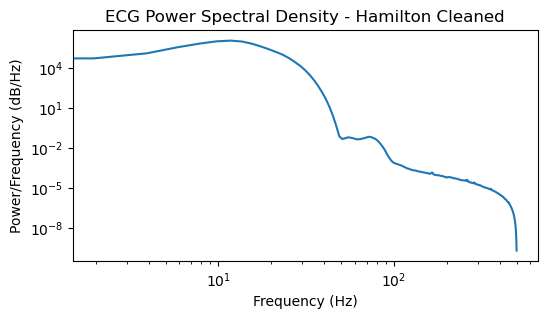

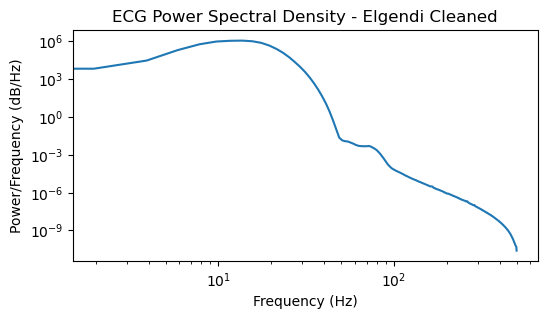

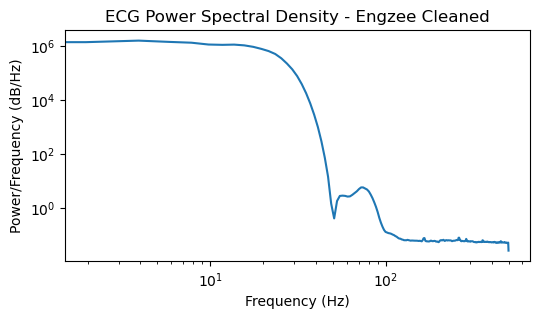

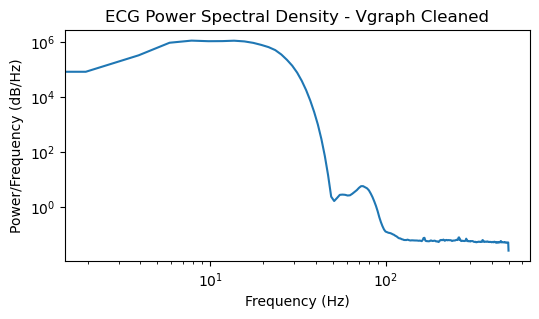

In [46]:


#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage


# Create a list to store cleaned signals for each method
cleaned_signals = []

# Apply each cleaning method and store the results
cleaning_methods = ["neurokit", "biosppy", "pantompkins", "hamilton", "elgendi", "engzee", "vgraph"]

# Create a color cycle for cleaned signals
colors = plt.cm.viridis(np.linspace(0, 1, len(cleaning_methods)))

# Create separate plots for cleaned signals
for i, method in enumerate(cleaning_methods):
    # Apply the cleaning method
    if method == "neurokit":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method='neurokit')
    elif method == "biosppy":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="biosppy")
    elif method == "pantompkins":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="pantompkins")
    elif method == "hamilton":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="hamilton")
    elif method == "elgendi":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="elgendi")
    elif method == "engzee":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="engzee")
    elif method == "vgraph":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="vgraph")

    cleaned_signals.append((ecg_cleaned, method, colors[i]))


# Plot all cleaned signals on the same plot
plt.figure(figsize=(11, 2))
for ecg_cleaned, method, color in cleaned_signals:
    plt.plot(ecg_cleaned[CROP_MIN:CROP_MAX], label=f'{method.capitalize()} Cleaned', color=color, alpha=1)

plt.title(f'Participant {SUB_NUM}: All Cleaned ECG Signals', size=10)
plt.xlim(0, 1500)  # Limit x-axis to 0-1500 ms
plt.legend(loc='upper right')
plt.show()

# For each cleaned signal, calculate the PSD and run fooof/spec param for each signal with a different cleaning method
for ecg_cleaned, method, _ in cleaned_signals:

    # Calculate the Power Spectral Density (PSD) using Welch's method
    f, Pxx = welch(ecg_cleaned, fs=1000, nperseg=nperseg, noverlap=noverlap)

    plt.figure(figsize=(6, 3))

    # Plot the Power Spectral Density (PSD) in log-log space
    plt.loglog(f, Pxx)
    plt.title(f'ECG Power Spectral Density - {method.capitalize()} Cleaned')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()


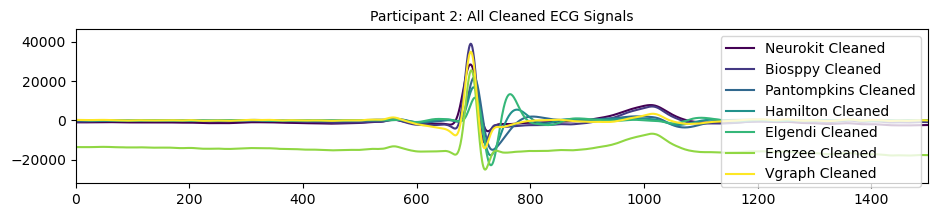

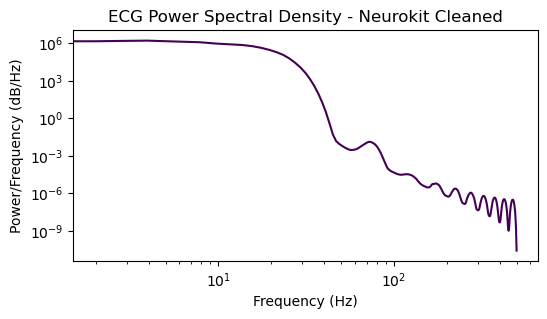

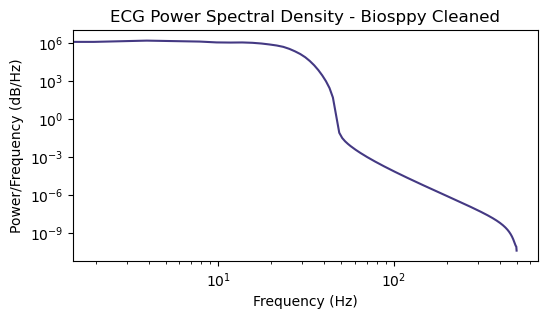

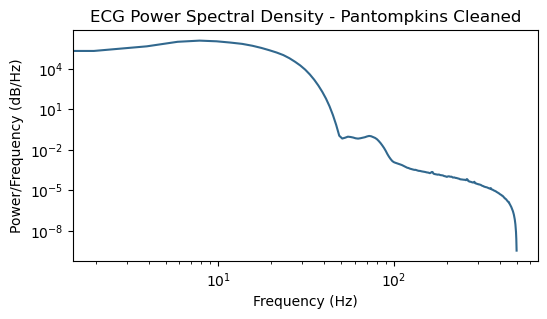

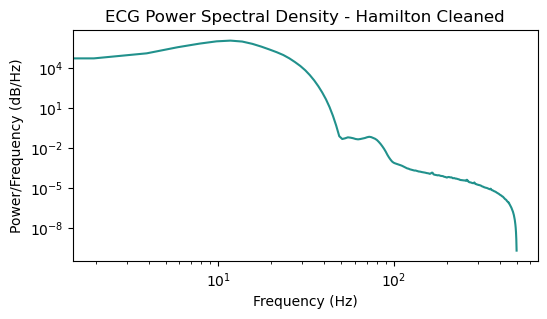

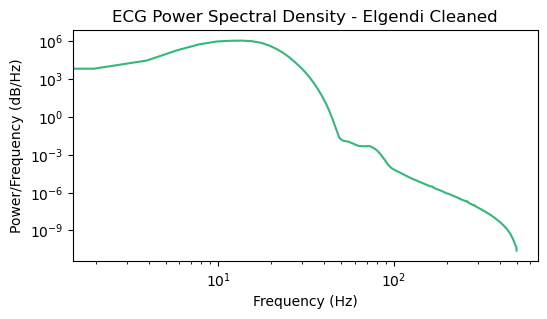

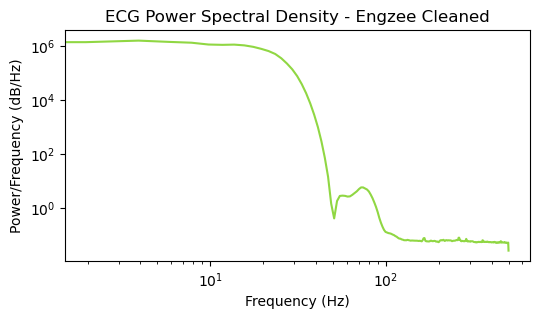

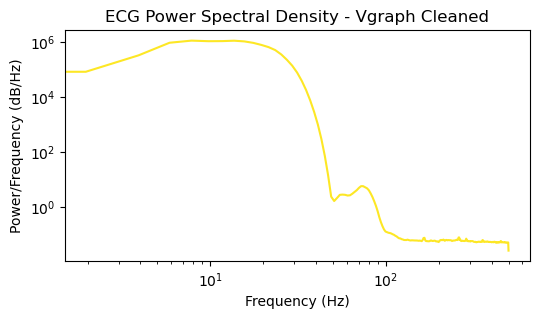

In [57]:
#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage

# Create a list to store cleaned signals for each method
cleaned_signals = []

# Apply each cleaning method and store the results
cleaning_methods = ["neurokit", "biosppy", "pantompkins", "hamilton", "elgendi", "engzee", "vgraph"]

# Create a color cycle for cleaned signals
colors = plt.cm.viridis(np.linspace(0, 1, len(cleaning_methods)))

# Create separate plots for cleaned signals
for i, method in enumerate(cleaning_methods):
    # Apply the cleaning method
    if method == "neurokit":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method='neurokit')
    elif method == "biosppy":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="biosppy")
    elif method == "pantompkins":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="pantompkins")
    elif method == "hamilton":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="hamilton")
    elif method == "elgendi":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="elgendi")
    elif method == "engzee":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="engzee")
    elif method == "vgraph":
        ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=1000, method="vgraph")

    cleaned_signals.append((ecg_cleaned, method, colors[i]))

# Plot all cleaned signals on the same plot with matching colors
plt.figure(figsize=(11, 2))
for ecg_cleaned, method, color in cleaned_signals:
    plt.plot(ecg_cleaned[CROP_MIN:CROP_MAX], label=f'{method.capitalize()} Cleaned', color=color, alpha=1)

plt.title(f'Participant {SUB_NUM}: All Cleaned ECG Signals', size=10)
plt.xlim(0, 1500)  # Limit x-axis to 0-1500 ms
plt.legend(loc='upper right')
plt.show()

# For each cleaned signal, calculate the PSD and run fooof/spec param for each signal with a different cleaning method
for ecg_cleaned, method, color in cleaned_signals:

    # Calculate the Power Spectral Density (PSD) using Welch's method
    f, Pxx = welch(ecg_cleaned, fs=1000, nperseg=nperseg, noverlap=noverlap)

    plt.figure(figsize=(6, 3))

    # Plot the Power Spectral Density (PSD) in log-log space with matching color
    plt.loglog(f, Pxx, color=color)
    plt.title(f'ECG Power Spectral Density - {method.capitalize()} Cleaned')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()



### Trimmed Signal

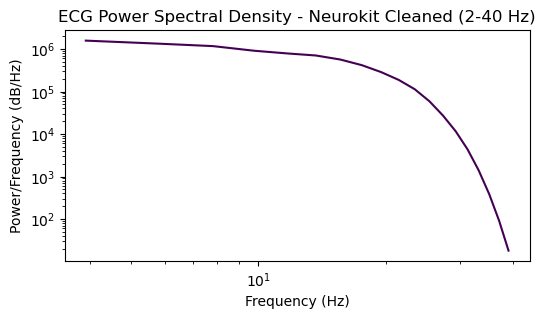


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

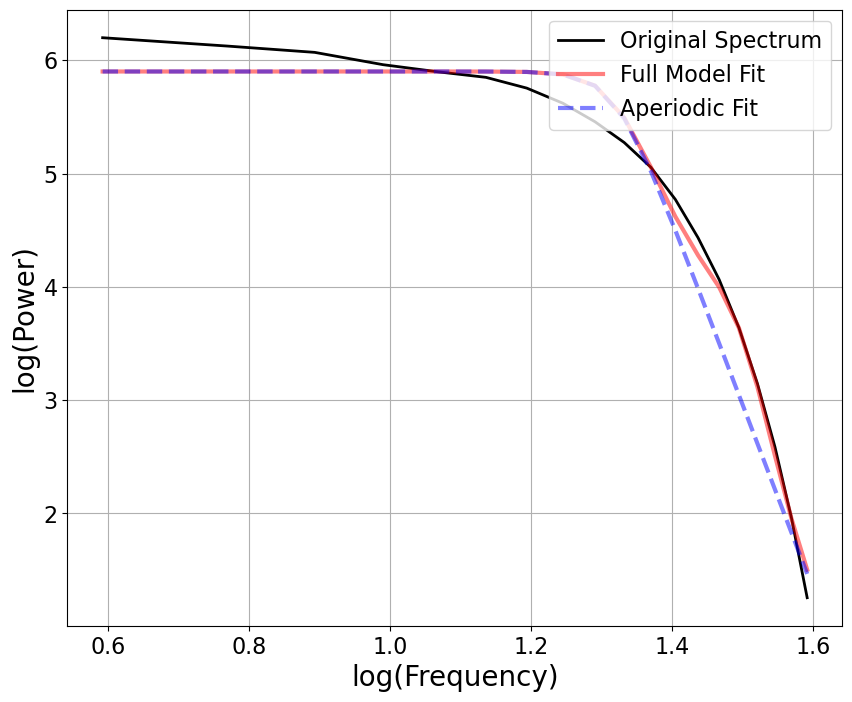

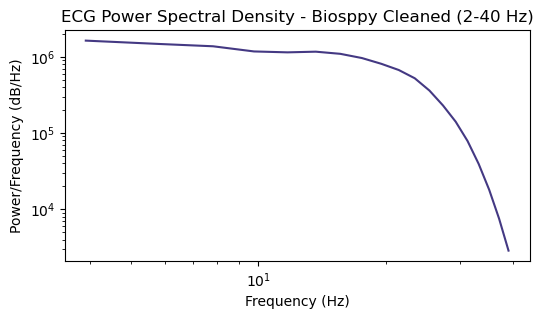


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

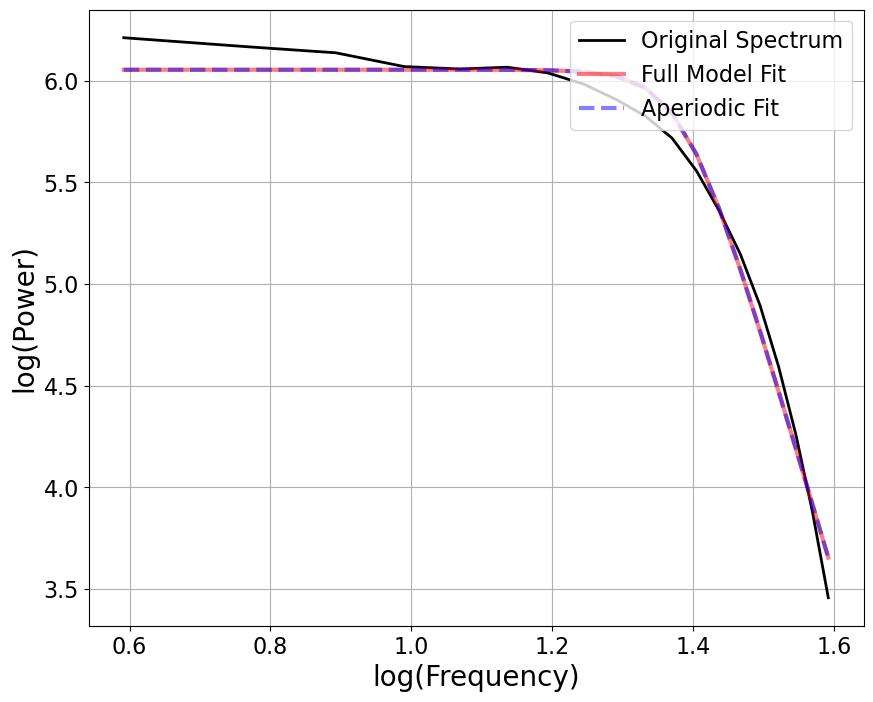

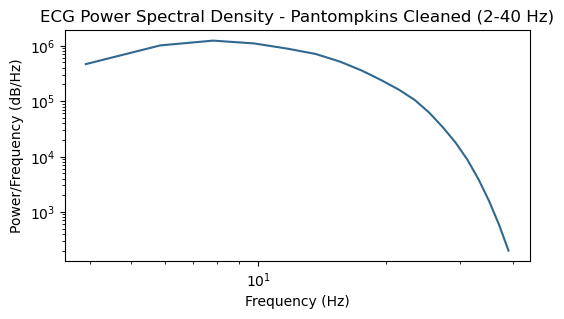


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

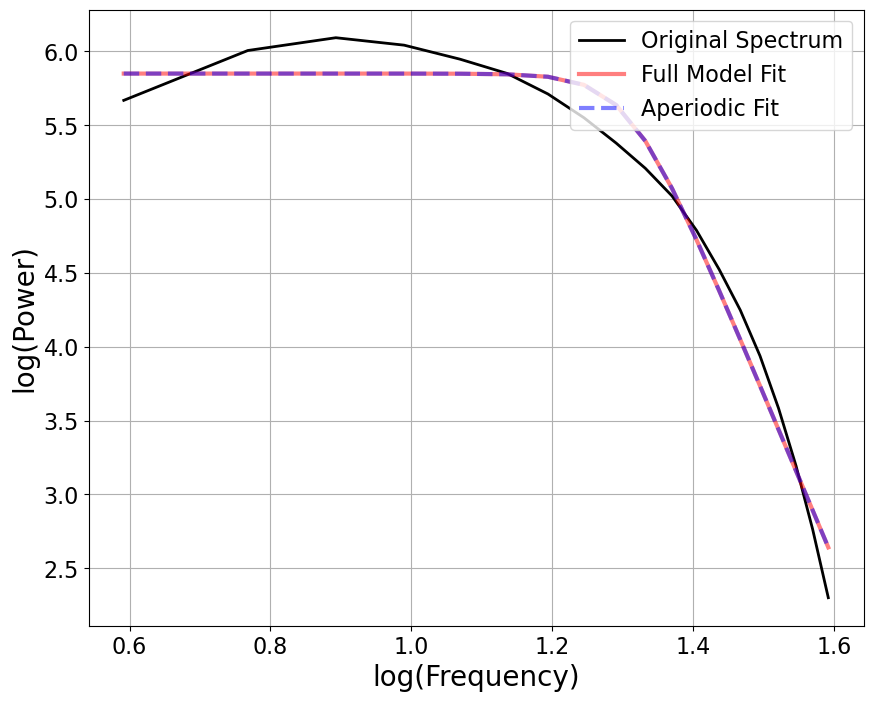

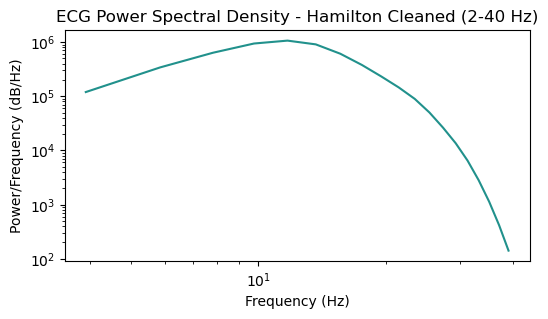


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

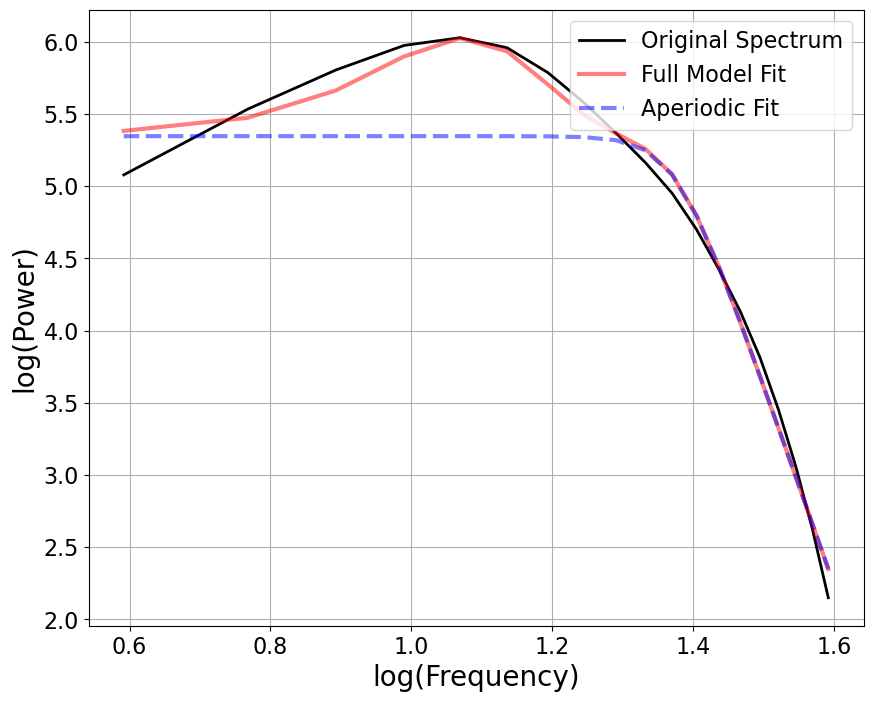

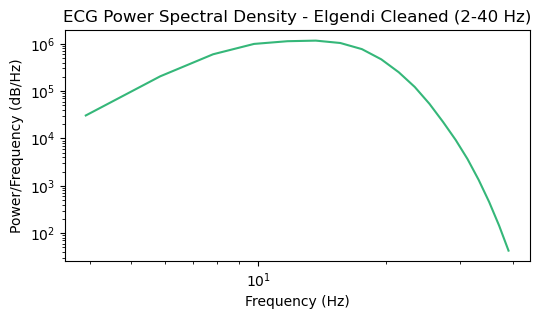


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

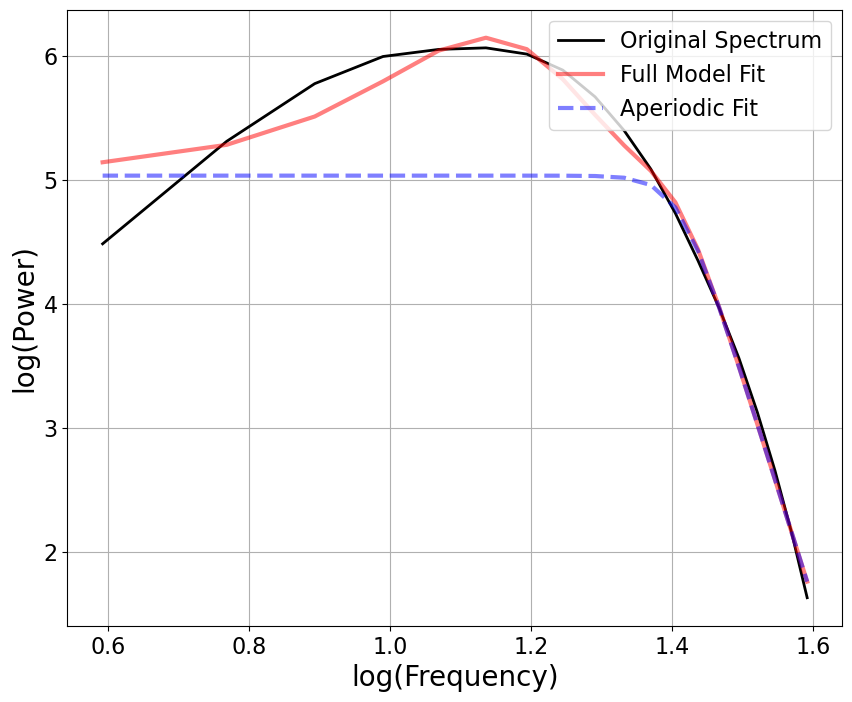

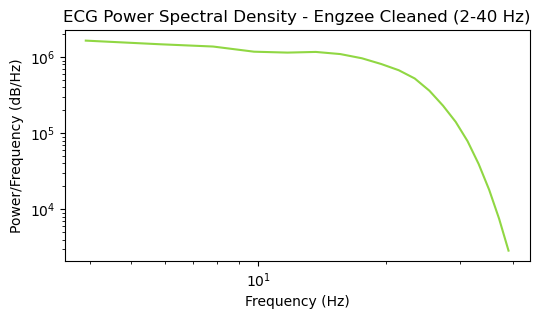


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

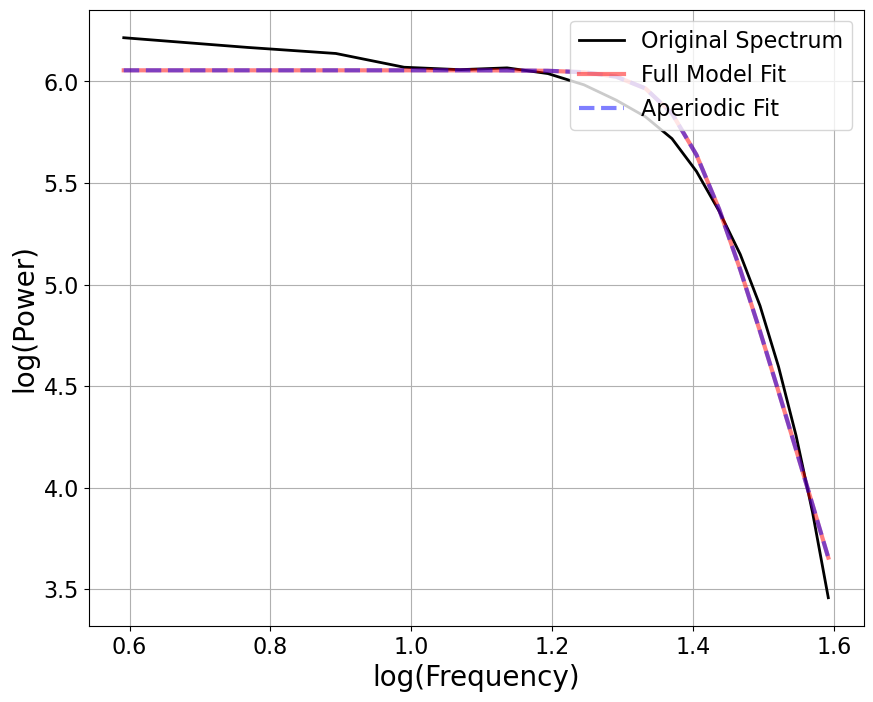

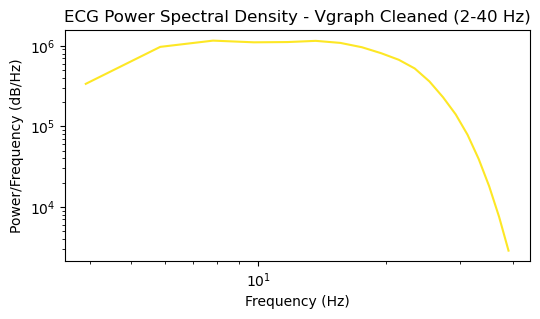


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

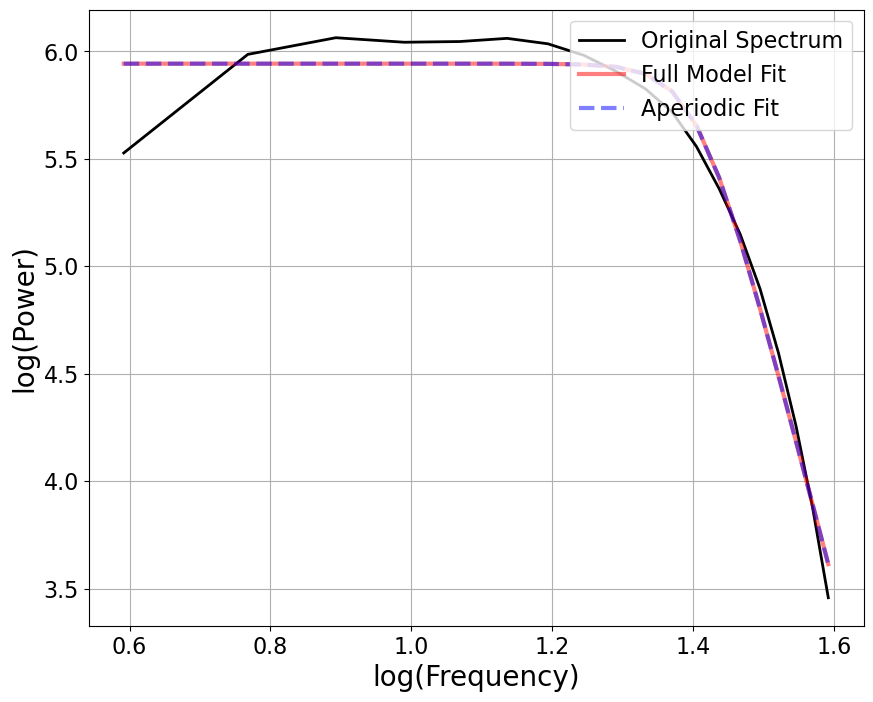

In [59]:
# For each cleaned signal, calculate the PSD and run fooof/spec param for each signal with a different cleaning method
for ecg_cleaned, method, color in cleaned_signals:

    # Calculate the Power Spectral Density (PSD) using Welch's method
    f, Pxx = welch(ecg_cleaned, fs=1000, nperseg=nperseg, noverlap=noverlap)

    # Limit the plot to the frequency range of 2-40 Hz
    freq_range_mask = (f >= 2) & (f <= 40)
    f_trimmed = f[freq_range_mask]
    Pxx_trimmed = Pxx[freq_range_mask]

    plt.figure(figsize=(6, 3))

    # Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
    plt.loglog(f_trimmed, Pxx_trimmed, color=color)
    plt.title(f'ECG Power Spectral Density - {method.capitalize()} Cleaned (2-40 Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # Apply FOOOF to the trimmed PSD
    fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
    fg.fit(f_trimmed, Pxx_trimmed)
    fg.report(plt_log=True)
    

   


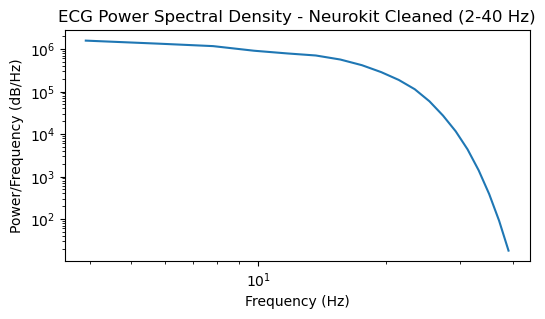


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

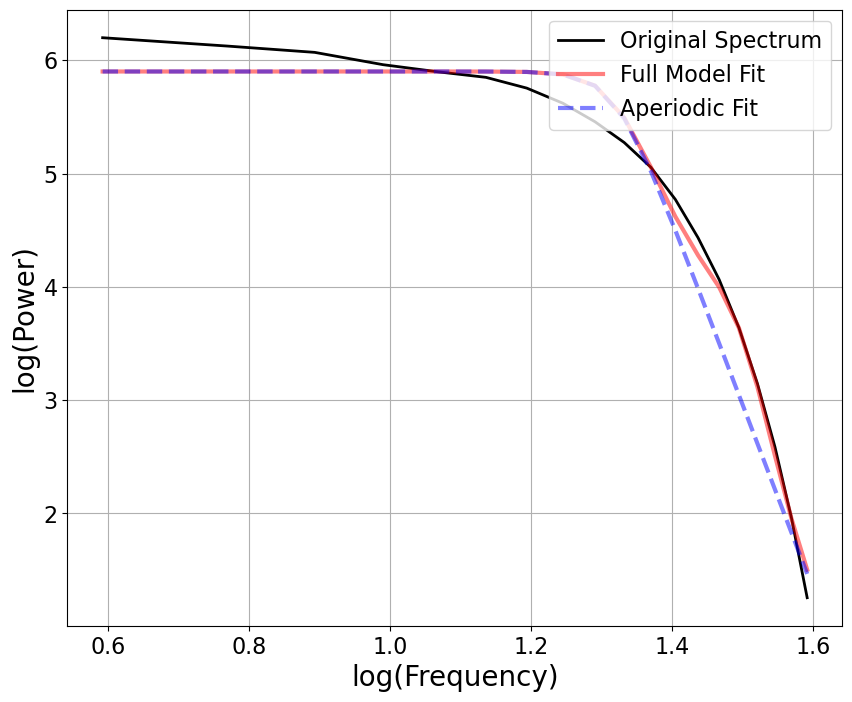

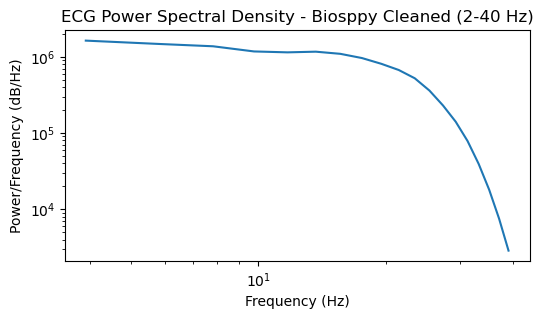


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

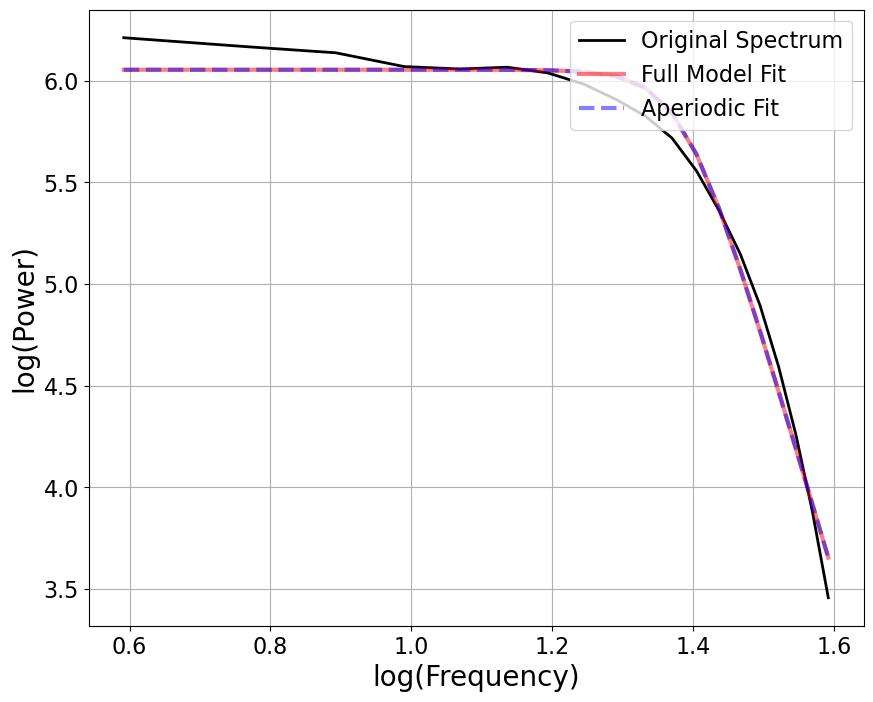

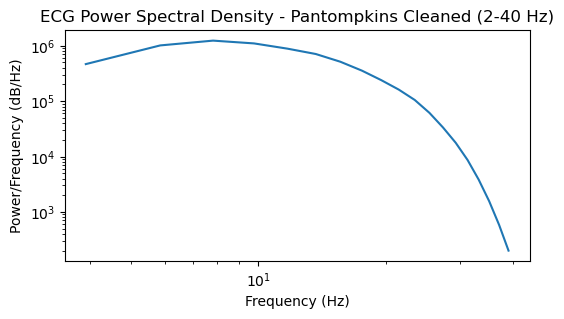


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

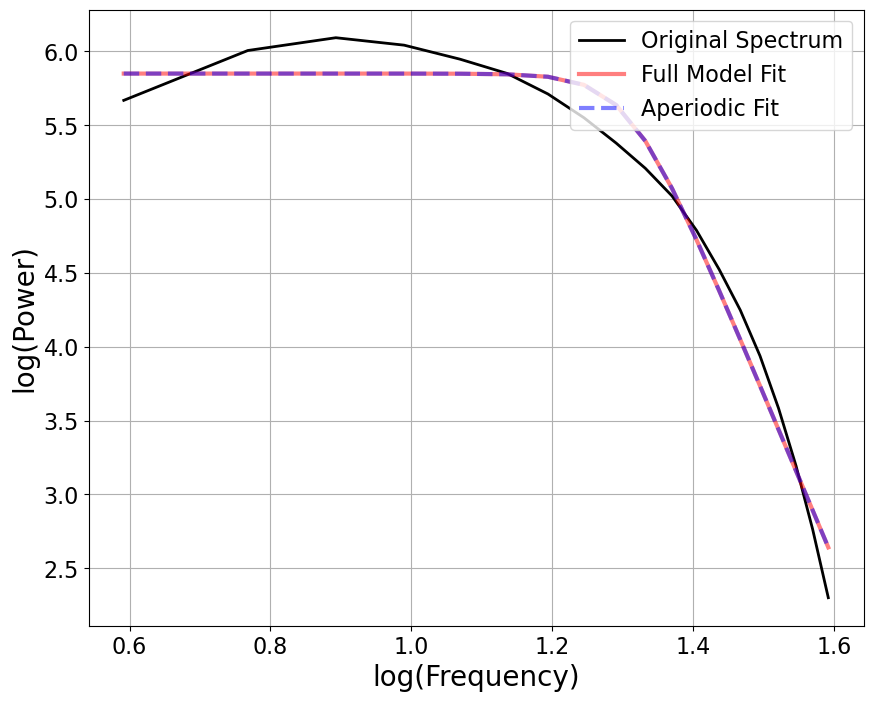

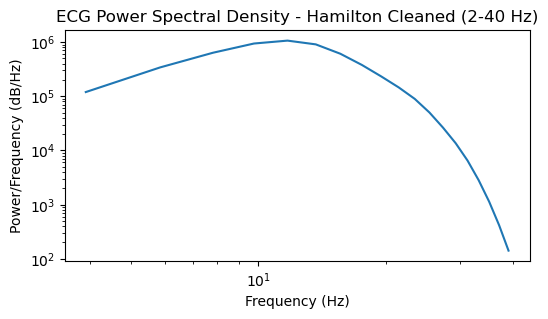


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

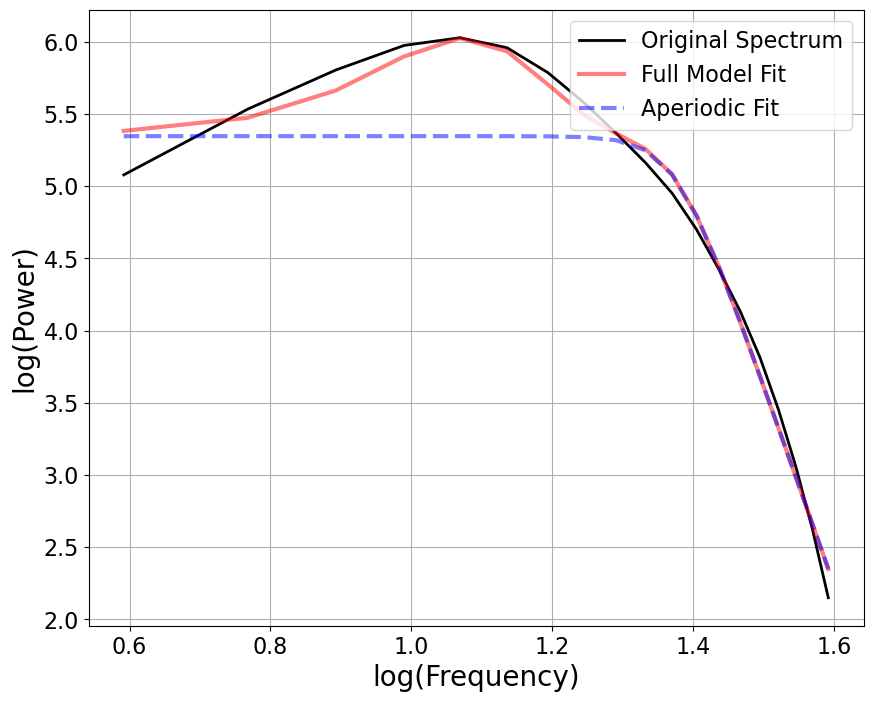

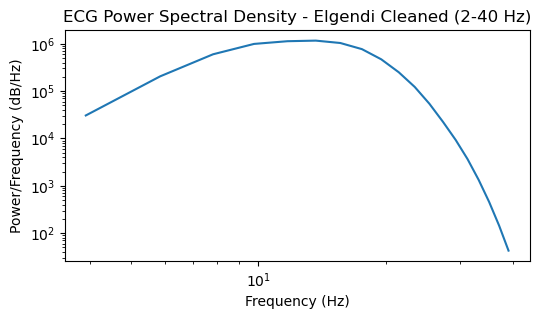


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

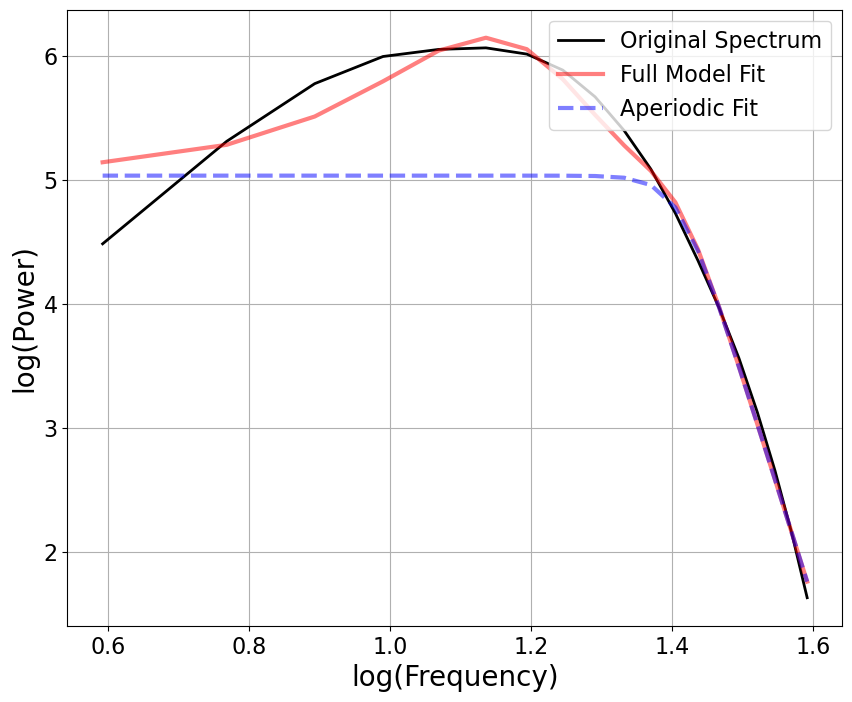

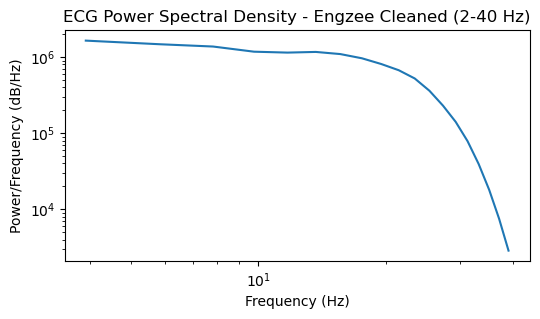


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

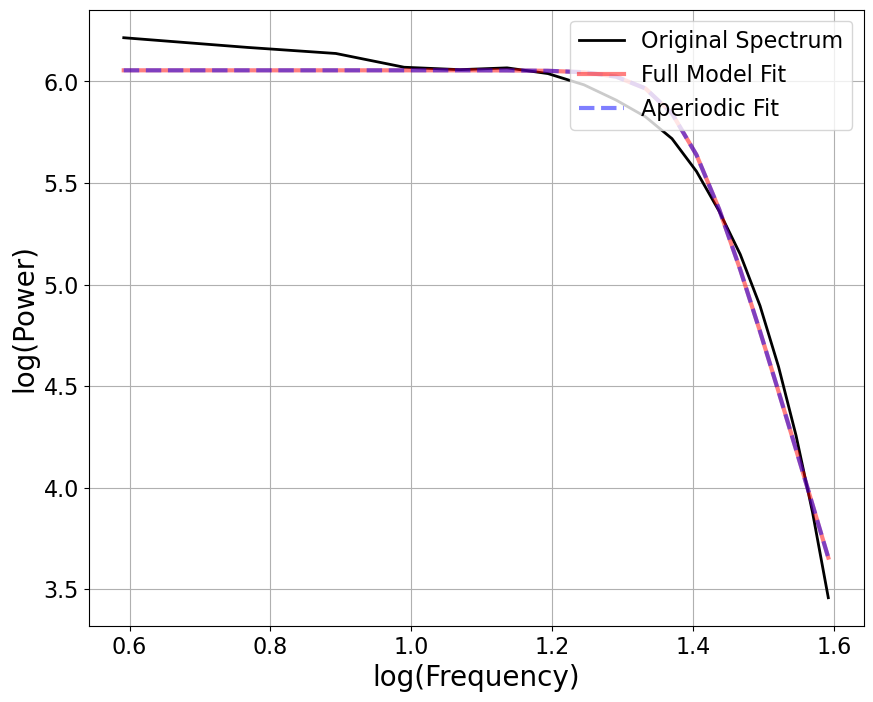

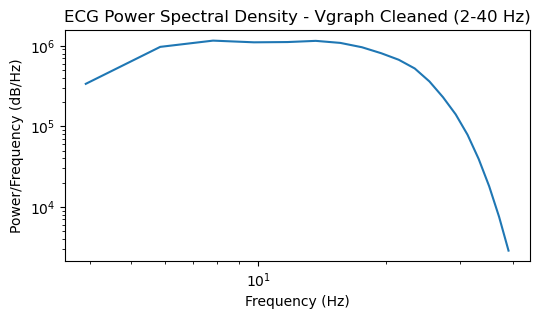


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

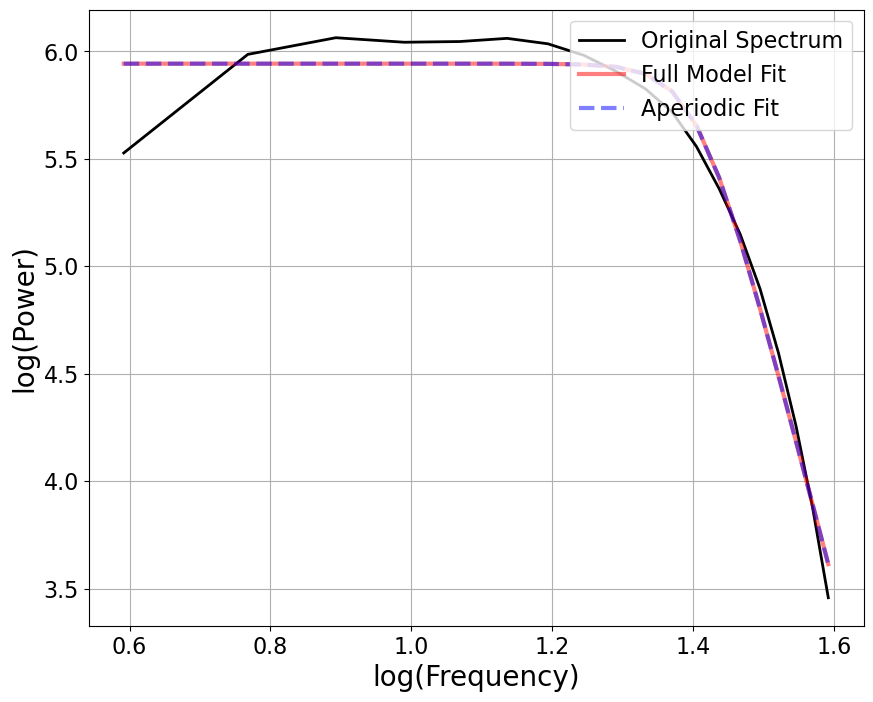

In [56]:
# For each cleaned signal, calculate the PSD and run fooof/spec param for each signal with a different cleaning method
for ecg_cleaned, method, _ in cleaned_signals:

    # Calculate the Power Spectral Density (PSD) using Welch's method
    f, Pxx = welch(ecg_cleaned, fs=1000, nperseg=nperseg, noverlap=noverlap)

    # Limit the plot to the frequency range of 2-40 Hz
    freq_range_mask = (f >= 2) & (f <= 40)
    f_trimmed = f[freq_range_mask]
    Pxx_trimmed = Pxx[freq_range_mask]

    plt.figure(figsize=(6, 3))

    # Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
    plt.loglog(f_trimmed, Pxx_trimmed)
    plt.title(f'ECG Power Spectral Density - {method.capitalize()} Cleaned (2-40 Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # Apply FOOOF to the trimmed PSD
    fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
    fg.fit(f_trimmed, Pxx_trimmed)
    fg.report(plt_log=True)
   


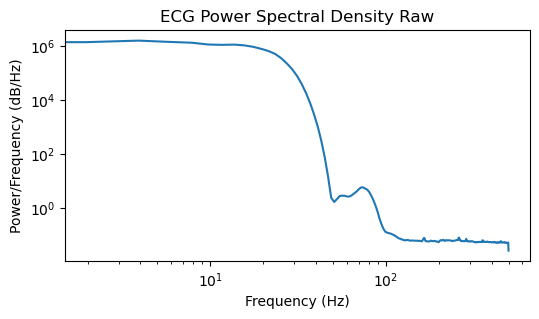

In [60]:

#Simple Welch Input
fs = 1000  # Sampling frequency (Hz)
nperseg = 512  # Example window length
noverlap = 256  # Example overlap percentage


# Calculate the Power Spectral Density (PSD) using Welch's method
f, Pxx = welch(ecg, fs=1000, nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space
plt.loglog(f, Pxx)
plt.title(f'ECG Power Spectral Density Raw')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

## Raw sig

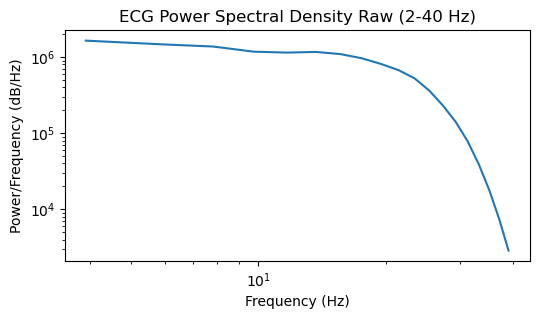


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.95 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  

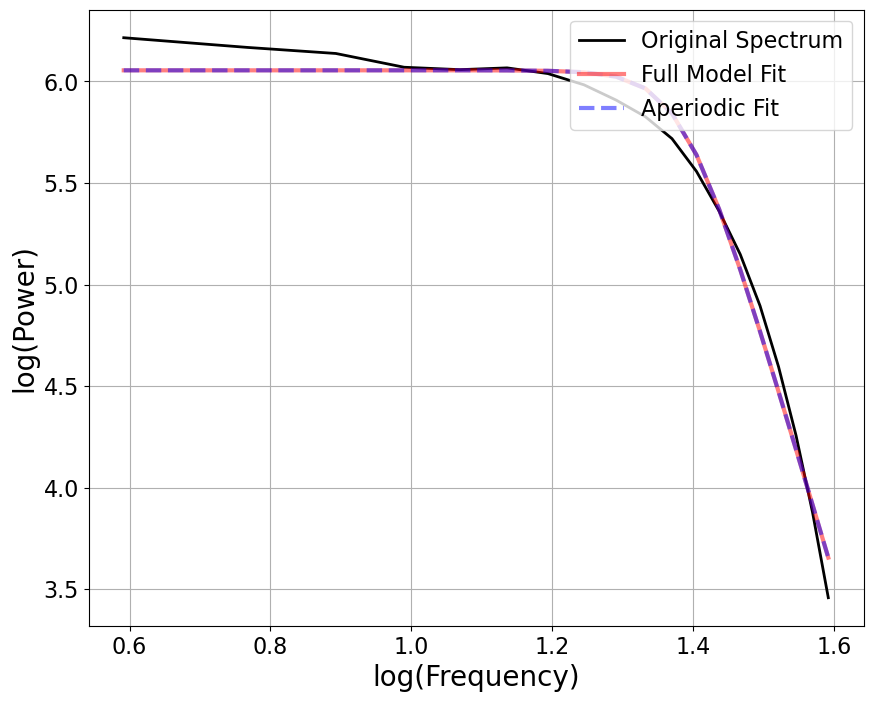

In [61]:

# Calculate the Power Spectral Density (PSD) using Welch's method
f, Pxx = welch(ecg, fs=1000, nperseg=nperseg, noverlap=noverlap)

# Limit the plot to the frequency range of 2-40 Hz
freq_range_mask = (f >= 2) & (f <= 40)
f_trimmed = f[freq_range_mask]
Pxx_trimmed = Pxx[freq_range_mask]

plt.figure(figsize=(6, 3))

# Plot the Power Spectral Density (PSD) in log-log space for the specified frequency range
plt.loglog(f_trimmed, Pxx_trimmed)
plt.title(f'ECG Power Spectral Density Raw (2-40 Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()

# Apply FOOOF to the trimmed PSD
fg = fooof.FOOOF(max_n_peaks=3, min_peak_height=0.5, aperiodic_mode='knee')
fg.fit(f_trimmed, Pxx_trimmed)
fg.report(plt_log=True)

